In [1]:
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import random


import torch.nn as nn
from torch.utils.data import DataLoader
from PIL import Image
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torch.utils import data
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm.notebook import tqdm

from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torchvision import datasets, models, transforms
import time

In [5]:
original_dataset_dir = '/work/mech-ai/nasla/Leaf_Images'

In [6]:
diseases = os.listdir(original_dataset_dir)
print(diseases)

['4', '3', '7', '8', '5', '1', '6']


In [177]:
transforms1=transforms.Compose([
#     give different bounding box sizes
   transforms.Resize((256, 256)),
   transforms.RandomHorizontalFlip(),
   transforms.RandomVerticalFlip(),
   transforms.RandomRotation((0, 90)),
   transforms.RandomAffine(degrees=(30, 40), translate=(0.1, 0.3), scale=(0.8, 0.8)), #shear, translate, scale
   transforms.ColorJitter(brightness=.5, hue=.0), # intensity/channels or brightness
   transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

In [178]:
dataset = ImageFolder(original_dataset_dir, transform=transforms1)

In [179]:
random_seed = 7
torch.manual_seed(random_seed)

In [180]:
lengths = [int(np.ceil(0.85*len(dataset))),
           int(np.floor(0.15*len(dataset)))]
train_set, test_set = data.random_split(dataset, lengths)
print('Train dataset:', len(train_set))
print('Test dataset:', len(test_set))

Train dataset: 12517
Test dataset: 2208


In [181]:
# setting the batch size
batch_size = 256

In [182]:
train_set_size = int(len(train_set) * 0.8)
valid_set_size = len(train_set) - train_set_size
train, valid = data.random_split(train_set, [train_set_size, valid_set_size])

In [183]:
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_set, batch_size, num_workers=4, pin_memory=True)

In [184]:
print(f"train data: {len(train_dl)}")
print(f"valid data: {len(valid_dl)}")
print(f"test data: {len(test_dl)}")

train data: 40
valid data: 10
test data: 9


In [186]:
img, label = train[3]
print(img.shape, label)

torch.Size([3, 256, 256]) 1


In [3]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda:0')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [4]:
device = get_default_device()
print(device)

cpu


In [5]:
#define the model by extending an ImageClassificationBase class with helper methods for training & validation.
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [16]:
# for bounding boxes 224x224
class Net_224(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 32 x 112 x 112
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 56 x 56

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 28 x 28

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 14 x 14
            
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 7 x 7

            nn.Flatten(), 
            nn.Linear(256*7*7, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 7))
    def forward(self, xb):
        return self.network(xb)

In [17]:
# for bounding boxes 128x128
class Net_128(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(), # output: 32 x 128 x 128
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 64 x 64

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(), 
            nn.MaxPool2d(2, 2), # output: 64 x 32 x 32

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 16 x 16
            
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 8 x 8

            nn.Flatten(), 
            nn.Linear(256*8*8, 1024),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 7))
    def forward(self, xb):
        return self.network(xb)

In [18]:
#for bounding boxes 256x256
class Net_256(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # nn.MaxPool2d(2, 2), # output: 32 x 256 x 256

            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 32 x 128 x 128
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 64 x 64

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(), 
            nn.MaxPool2d(2, 2), # output: 64 x 32 x 32

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 16 x 16
            
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 8 x 8

            nn.Flatten(), 
            nn.Linear(256*8*8, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 7))
        
    def forward(self, xb):
        return self.network(xb)

In [198]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit_OneCycle(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.adam):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), lr)

    
    
    for epoch in range(1, len(range(epochs+1))):
        # Training Phase 
        model.train()
        train_losses = []
            
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['epoch'] = epoch
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [202]:
epochs = 50
lr = 0.0003
opt_func = torch.optim.Adam

In [7]:
model = to_device(Net_256(), device)
model

Net(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=

In [204]:
%%time
history = fit_OneCycle(epochs, lr, model, train_dl, valid_dl, 
                             opt_func=opt_func)

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1], train_loss: 1.8019, val_loss: 1.6680, val_acc: 0.4072


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [2], train_loss: 1.5458, val_loss: 1.5268, val_acc: 0.4740


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [3], train_loss: 1.3673, val_loss: 1.2161, val_acc: 0.5872


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [4], train_loss: 1.1586, val_loss: 0.9940, val_acc: 0.6385


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.9819, val_loss: 1.0028, val_acc: 0.6444


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.9070, val_loss: 0.8559, val_acc: 0.6916


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.8481, val_loss: 0.7413, val_acc: 0.7477


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.7528, val_loss: 0.7960, val_acc: 0.7005


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.7249, val_loss: 0.6399, val_acc: 0.7722


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.6721, val_loss: 0.5881, val_acc: 0.7933


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.6692, val_loss: 0.6971, val_acc: 0.7556


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.6432, val_loss: 0.5625, val_acc: 0.8019


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.6025, val_loss: 0.5662, val_acc: 0.8020


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.5696, val_loss: 0.4787, val_acc: 0.8406


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.5457, val_loss: 0.4905, val_acc: 0.8222


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.5247, val_loss: 0.7390, val_acc: 0.7313


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.5755, val_loss: 0.4962, val_acc: 0.8262


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.5158, val_loss: 0.4477, val_acc: 0.8427


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.4857, val_loss: 0.5096, val_acc: 0.8246


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.4817, val_loss: 0.4144, val_acc: 0.8579


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.4386, val_loss: 0.3966, val_acc: 0.8593


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.4385, val_loss: 0.5442, val_acc: 0.8297


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.4448, val_loss: 0.3961, val_acc: 0.8595


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.4044, val_loss: 0.4496, val_acc: 0.8399


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.4298, val_loss: 0.3874, val_acc: 0.8693


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.3871, val_loss: 0.3409, val_acc: 0.8811


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.3911, val_loss: 0.3428, val_acc: 0.8751


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.3622, val_loss: 0.4071, val_acc: 0.8599


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.3812, val_loss: 0.3518, val_acc: 0.8787


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [30], train_loss: 0.3578, val_loss: 0.3344, val_acc: 0.8780


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [31], train_loss: 0.3606, val_loss: 0.4127, val_acc: 0.8516


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [32], train_loss: 0.3680, val_loss: 0.3100, val_acc: 0.8896


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [33], train_loss: 0.3223, val_loss: 0.3815, val_acc: 0.8699


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [34], train_loss: 0.3487, val_loss: 0.3683, val_acc: 0.8667


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [35], train_loss: 0.3374, val_loss: 0.3256, val_acc: 0.8912


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [36], train_loss: 0.3213, val_loss: 0.3016, val_acc: 0.8941


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [37], train_loss: 0.3422, val_loss: 0.3336, val_acc: 0.8819


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [38], train_loss: 0.2968, val_loss: 0.3119, val_acc: 0.8890


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [39], train_loss: 0.3049, val_loss: 0.2962, val_acc: 0.8878


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [40], train_loss: 0.3182, val_loss: 0.3608, val_acc: 0.8715


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [41], train_loss: 0.2897, val_loss: 0.3471, val_acc: 0.8847


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [42], train_loss: 0.3009, val_loss: 0.2957, val_acc: 0.8962


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [43], train_loss: 0.2908, val_loss: 0.3482, val_acc: 0.8870


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [44], train_loss: 0.2980, val_loss: 0.2640, val_acc: 0.9038


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [45], train_loss: 0.2633, val_loss: 0.2738, val_acc: 0.9029


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [46], train_loss: 0.2677, val_loss: 0.2633, val_acc: 0.9005


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [47], train_loss: 0.2822, val_loss: 0.2619, val_acc: 0.9103


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [48], train_loss: 0.2860, val_loss: 0.3065, val_acc: 0.8870


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [49], train_loss: 0.2754, val_loss: 0.3121, val_acc: 0.8923


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [50], train_loss: 0.2655, val_loss: 0.2932, val_acc: 0.8983
CPU times: user 4min 16s, sys: 51.2 s, total: 5min 7s
Wall time: 1h 2min 1s


In [207]:
torch.save(model.state_dict(), '/work/mech-ai/mozhgan/Me592/ME592_HW3_256.pth')
torch.save(model.state_dict(), '/work/mech-ai/mozhgan/Me592/ME592_HW3_224.pth')
torch.save(model.state_dict(), '/work/mech-ai/mozhgan/Me592/ME592_HW3_128.pth')

In [8]:
#Remove background:
import cv2
import matplotlib.pyplot as plt
import numpy as np
for i in range(1,11):
    image=cv2.imread('/work/mech-ai/mozhgan/Me592/Data/canopy/'+str(1000+i)+'.jpg')
    image_hsv=cv2.cvtColor(image,cv2.COLOR_RGB2LAB)
    ret,image_result=cv2.threshold(image_hsv[:,:,1],0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    image_result=cv2.morphologyEx(image_result, cv2.MORPH_CLOSE, kernel)
    crop=cv2.bitwise_and(image,image,mask=image_result)
    cv2.imwrite('/work/mech-ai/mozhgan/Me592/Data/canopy/Img_remove_background/'+str(i)+'.png', crop)
    

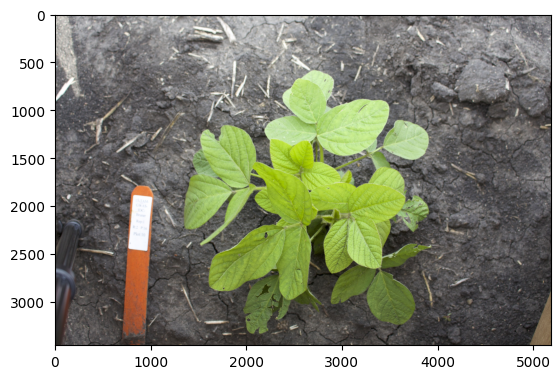

In [9]:
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

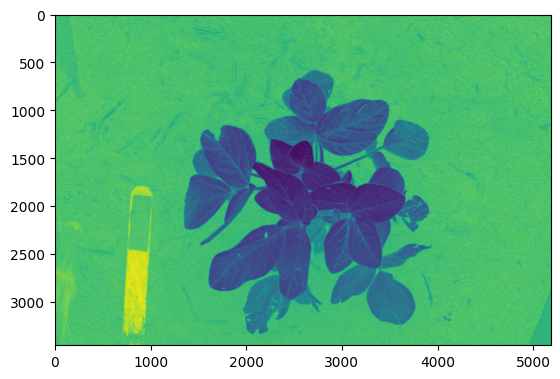

In [10]:
plt.imshow(image_hsv[:,:,1])

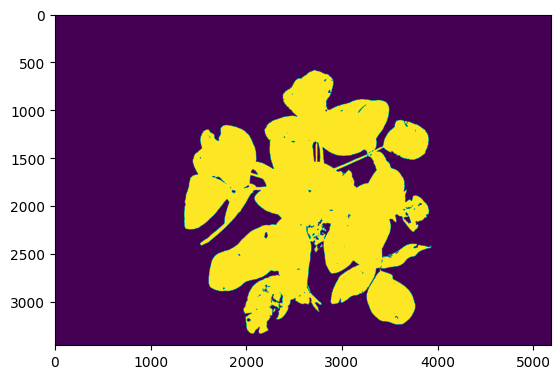

In [11]:
plt.imshow(image_result)

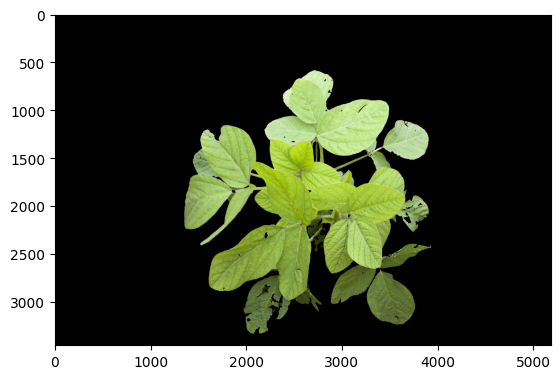

In [12]:
plt.imshow(cv2.cvtColor(crop,cv2.COLOR_BGR2RGB))

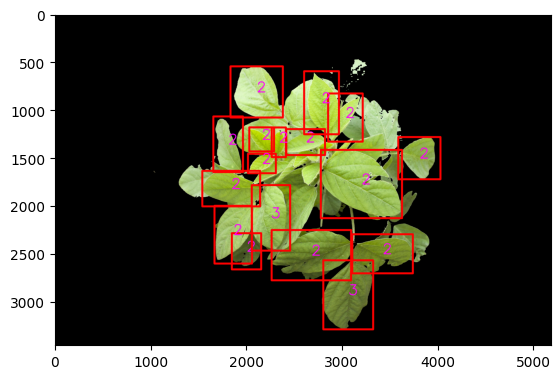

In [31]:
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import numpy as np

device = torch.device("cpu" if torch.cuda.is_available() else "cpu")

image=cv2.imread('/work/mech-ai/mozhgan/Me592/Data/canopy/Image_annotated/2_i.jpg')
image_original=cv2.imread('/work/mech-ai/mozhgan/Me592/Data/canopy/Img_remove_background/2.png')
image_original=cv2.cvtColor(image_original,cv2.COLOR_BGR2RGB)

model_256 = Net_256()
model_256.load_state_dict(torch.load("/work/mech-ai/mozhgan/Me592/ME592_HW3_256.pth", map_location=device))
model_224 = Net_224()
model_224.load_state_dict(torch.load("/work/mech-ai/nasla/ME592_HW3_224.pth", map_location='cpu'))
model_128 = Net_128()
model_128.load_state_dict(torch.load("/work/mech-ai/nasla/ME592_HW3_128.pth", map_location='cpu'))

image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image_lab=cv2.cvtColor(image,cv2.COLOR_RGB2LAB)
ret,image_result=cv2.threshold(image_lab[:,:,1],0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

contours = cv2.findContours(image_result, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contours = contours[0] if len(contours) == 2 else contours[1]
image_original_copy=image_original.copy()

s_128=[]
s_224=[]
s_256=[]

for c in contours:
    x,y,w,h=cv2.boundingRect(c)
    cv2.rectangle(image_original_copy,(x,y),(x+w,y+h),(255,0,0),20)
    ROI=cv2.resize(image_original[y:y+h,x:x+w],(128, 128))
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    ROI_tensor = transform(ROI).unsqueeze(0).to(device)
    with torch.no_grad():
        prediction_128 = model_128(ROI_tensor)
    p_128 = prediction_128.cpu().numpy()[0].argmax()+1
    s_128.append(p_128)
    
    ROI=cv2.resize(image_original[y:y+h,x:x+w],(224, 224))
    ROI_tensor = transform(ROI).unsqueeze(0).to(device)
    with torch.no_grad():
        prediction_224 = model_224(ROI_tensor)
    p_224 = prediction_224.cpu().numpy()[0].argmax()+1
    s_224.append(p_224)

    ROI=cv2.resize(image_original[y:y+h,x:x+w],(256, 256))
    ROI_tensor = transform(ROI).unsqueeze(0).to(device)
    with torch.no_grad():
        prediction_256 = model_256(ROI_tensor)
    p_256 = prediction_256.cpu().numpy()[0].argmax()+1
    s_256.append(p_256)

    ps=[p_128,p_224,p_256]
    # ps=[p_256]

    k=[j for i, j in enumerate(ps) if ps[:i].count(j) == 1]
  
    if(k!=[]):
        p=k[0]
    else:
        p=ps[0]
    cv2.putText(image_original_copy, str(p), (x+w//2,y+h//2), cv2.FONT_HERSHEY_SIMPLEX, 5, (255,0,255), 10)
plt.imshow(image_original_copy)
plt.show()

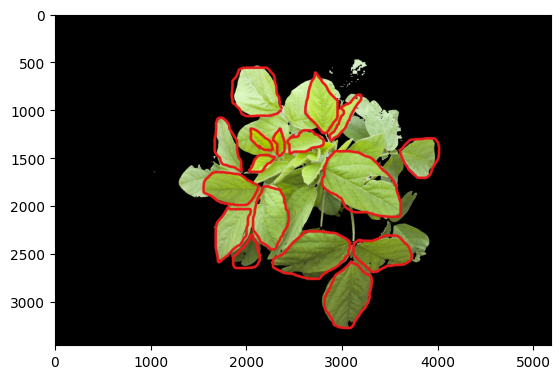

In [27]:
plt.imshow(image)

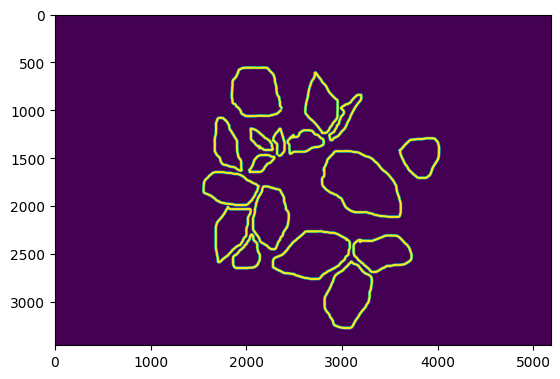

In [28]:
plt.imshow(image_result)

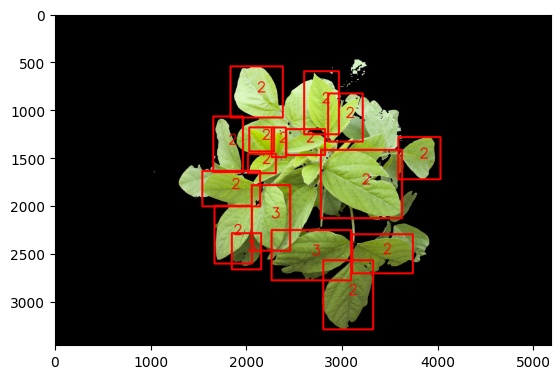

In [29]:
plt.imshow(image_original_copy)

# Hyperparamter Optimization:

For the hyperparameter optimization, we started with three boubding box sizes, 128x128, 224x224, and 256x256. We got the best accuracy for 256x256. 

We tried different learning rates such as 1e-2, 1e-3 and 3e-4., and the lr of 3e-4 gave us the best accuracy. 

Changing the depth of the network: With changing bounding boxes, we also changed the depth of the network. 
Adding one layer increased the performance a little bit, but adding more than two layers did not help. Adding more layers sometimes overfit the dataset. 

Dropot: We added dropout to the last layer. Adding dropout increased the performance of the classifier. Increasing the dropout probability from 0.2 to 0.5 increased the accuracy.